<a href="https://colab.research.google.com/github/kalvin807/COMP3359/blob/master/%5BGPU_FARM%5D_COMP3359_group_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP3359 Project
## Group 28: Classification of Tropical Cyclone Satellite Image by Intensity

---

### Introduction
In this project, we intend to develop a CNN-based model that accepts a satellite image of a tropical cyclone as input and
predicts a label the appropriate Dvorak T-number (a measure of tropical cyclone intensity) for it.
The T-number is derived using a manual method known as the Dvorak Technique (Dvorak,
1975; Dvorak, 1984) and we intend to let an AI model perform it without knowing the exact rules
and features to look for.

The dataset used is obtained from the website “Digital Typhoon”, a platform that
provides historical data (including satellite images) of tropical cyclones, provided by Prof. A. Kitamoto of
National Institute of Informatics (Japan), to whom we are highly indebted for his kind permission to use his data.

This notebook will be the implementation of our methodology, which is essentially a CNN multi-class image classifier.

References used:
- Dvorak, V.F. (1975, 5) Tropical Cyclone Intensity Analysis and Forecasting From
Satellite Imagery. Monthly Weather Review , Volume 3, pp.420-430.
- Dvorak, V.F. (1984) Tropical Cyclone Intensity Analysis Using Satellite Data. National
Oceanic and Atmospheric Administration. Washington D.C.: National Oceanic and
Atmospheric Administration.

### Table of Content


---
- Preperation
- Prerequisite
- Data Exploration and Preprocesssing
- [Interim Prototype] Building and Training a Model - Take 1: Pre-trained Net
- [Interim Prototype] Building and Training a Model - Take 2: Custom CNN
- [Interim Prototype] Conclusions about the two models



### Preperation

> This notebook designs to run un HKU GPU Farm, running it in colab will not work.

#### About data format
1. Why do we change the raw data to hdf5 file?  
    Due to limited size in both colab and HKU gpu farm, we are unable to load all pickel file to VM's disk. Accessing them from google drive also super slow and unstable. Therefore, we merge them into once single hdf5 file with compression, which is 20% of orginial size. Also, hdf5 supports concurrent read which further speed up loading speed.
2. Why we compress images from float32 to uint8 images
    It also due to the disk limitation and we also found there is no big different in terms of quality.

In [0]:
""" Install correct pytorch version """
# Uncomment % ... to see your CUDA version
# !/usr/local/cuda/bin/nvcc --version

# If you are using CUDA 10.0 (HKU GPU Phrase 1)
# !pip install pytorch==1.2.0 torchvision==0.4.0 cudatoolkit==10.0 Pillow==6.1

# If you have CUDA 10.1
# !pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# If you have CUDA 10.2
# !pip install pytorch torchvision

' If you are CUDA > 10.0 '

In [0]:
""" Python packages you might need """
# !pip install h5py opencv-python
# !pip install efficientnet-pytorch

' Python packages you might need '

In [0]:
""" Import packages """
import os
import sys
import numpy as np
import pandas as pd
import glob
import h5py
import torch

In [0]:
""" Set path to data: """
# WE dumped everything at root, so yeah.
dataset_dir = '.'
sys.path.append(dataset_dir)
IMAGES_H5 = 'images.hdf5'

In [0]:
# Know more about your machine
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU")
print(os.cpu_count())

GeForce GTX 1080 Ti
16


In [0]:
# Load attribute of images from csv
labels = pd.read_csv(f"{dataset_dir}/labels_with_images.csv")
len(labels)

163665

In [0]:
# Append few extra column of data for later use
labels = labels[['sequence','raw_index','datetime', 'class', 'latitude', 'longitude','pressure', 'TCxETC']]
labels['year'] = pd.to_datetime(labels['datetime'], format='%Y-%m-%d %X').dt.year
labels['month'] = pd.to_datetime(labels['datetime'], format='%Y-%m-%d %X').dt.month
labels['day'] = pd.to_datetime(labels['datetime'], format='%Y-%m-%d %X').dt.day
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163665 entries, 0 to 163664
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sequence   163665 non-null  int64  
 1   raw_index  163665 non-null  int64  
 2   datetime   163665 non-null  object 
 3   class      163665 non-null  int64  
 4   latitude   163665 non-null  float64
 5   longitude  163665 non-null  float64
 6   pressure   163665 non-null  float64
 7   TCxETC     163665 non-null  int64  
 8   year       163665 non-null  int64  
 9   month      163665 non-null  int64  
 10  day        163665 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 13.7+ MB


In [0]:
# If your instance have ##50GB## free memory, you can load everything into memory (Super Fast)
# This will take a while (5 mins + depending on your disk io)
def loadImgToRAM():
  with h5py.File(f"{dataset_dir}/{IMAGES_H5}", "r") as h5:
    return {label:h5[label][()] for label in h5.keys()}
IMGS_DICT = loadImgToRAM()

In [0]:
# Helper function to get a image from dict
def getImageFromDict(imgs_dict, row):
  img_name = f"{row['sequence']}{row['raw_index']}"
  return imgs_dict[img_name]

In [0]:
# Alternatively you can load a particular image directly from disk (Slow)
# Helper function to get a image array from HDF5 file
def getImageFromH5(h5, row):
        img_name = f"{row['sequence']}{row['raw_index']}"
        return h5[img_name][()]

## Data Exploration and Preprocessing

As mentioned in the proposal, we intend to use the dataset by Prof. A. Kitamoto of the National Institute of Informatics (Japan). Via his website “Digital Typhoon”, a platform that provides historical data (including satellite images) of tropical cyclones, we would likely obtain his research dataset for the use of this project. However Prof. Kitamoto only replied to us on 17 April evening and as a result, we proceeded to obtain training data by means of web scraping, in order to get hands-on experience about how the data would be like. 

The dataset we obtained consists of over 9000 images. Here are some code to look into the overall statistics of the dataset.

#### Exploring the data [Needs Update]
Organisation of dataset folder:


```
dataset_combined/      #root folder
|-- csvs               #contains csv files for each typhoon
|-- images             #monstrously huge folder of images
|-- typhoon_labels.csv #csv containing paths to images and all other data
```

Content of the dataset _as of now (15 April, 2020)_:
* 9317 images of 260 tropical cyclones (TCs) in the Northwestern Pacific basin between 2009 and 2019 inclusive
  * Each image is 512x512 monochrome, already centered on the TC.
  * More precisely, they are BD-enhanced (coloured) infrared images, the kind of infrared images human analysts would use to perform the Dvorak Technique.
* Other data included for each image: 
  * an identifier (id): year + number (e.g. 200901) as assigned by the JMA
  * name of the tropical cyclone
  * date (Y,M,D) and time (hour, 24h system) of the image
  * latitude and longitude of the TC in the image
  * central pressure (hectopascals/hPa) and wind speed (knots/kt)
  * class: intensity of the TC, as classified by the website. Not useful for our cause, as the classification systems are different.
  * img: file name of the image in the images folder
  * chart: a link to the track chart on the source website

Some of the above are going to be unused and would be dropped in due course.


In [0]:
# Lets go with import as usual
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Sample data:


<Figure size 720x720 with 0 Axes>

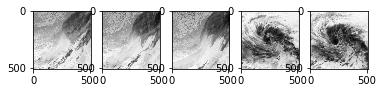

In [0]:
# Let's look at some sample images
plt.figure(figsize=(10,10))
print("Sample data:")
fig, ax = plt.subplots(1,5)
with h5py.File(f"{dataset_dir}/{IMAGES_H5}", 'r') as h5:
    for i in range(5):
      img = getImageFromH5(h5, labels.loc[i])
      ax[i].imshow(img, cmap='gray')
plt.show()

In [0]:
# Labels of each row
list(labels.columns.values)

['sequence',
 'raw_index',
 'datetime',
 'class',
 'latitude',
 'longitude',
 'pressure',
 'TCxETC',
 'year',
 'month',
 'day']

Classes: [0 1 2 3 4 5]
Distribution 
0    42312
3    40694
1    36358
2    25703
4    18447
5      151
Name: class, dtype: int64


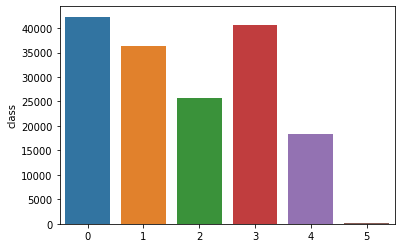

In [0]:
# Class
classes = np.sort(labels['class'].unique())
print("Classes:", classes)
print("Distribution ")
dist = labels['class'].value_counts()
print(dist)
sns.barplot(dist.index, dist)

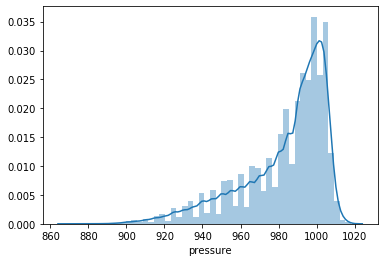

In [0]:
# Pressure distribution
pressure = labels['pressure']
sns.distplot(pressure)

In [0]:
# Pressure decile
decile = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
cutoff = pressure.quantile(decile)
print("Median of each quantile")
print(cutoff)
qcutted = pd.qcut(pressure, 10, labels=False)
print("Number of image in each bin")
qcutted.value_counts().sort_index()

Median of each quantile
0.1     950.000000
0.2     965.000000
0.3     977.000000
0.4     985.000000
0.5     990.666667
0.6     995.000000
0.7     998.000000
0.8    1002.000000
0.9    1004.000000
Name: pressure, dtype: float64
Number of image in each bin


0    18833
1    14951
2    15325
3    19252
4    13710
5    16662
6    16263
7    20964
8    12134
9    15571
Name: pressure, dtype: int64

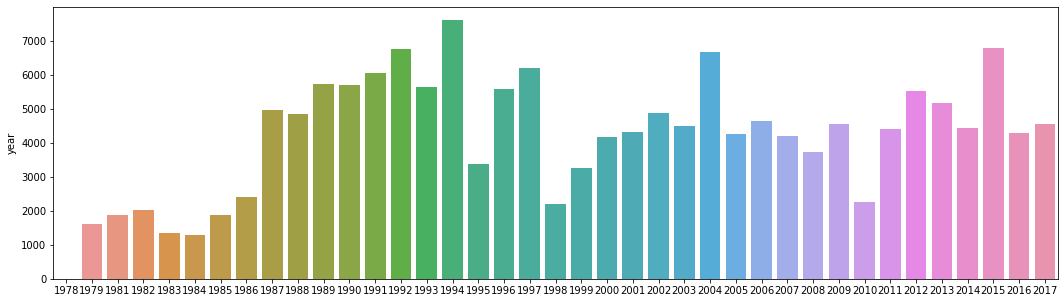

In [0]:
# By Year
years = labels['year']
count_years = years.value_counts()
plt.figure(figsize=(18,5))
sns.barplot(count_years.index, count_years)

#### Observations [Needs Update]
There are some observations we made about the dataset.
* The images do not zoom closely to the TC and sometimes capture a nearby TC.
  * This is an issue with the data source.
  * We would bear with it for now and observe what is going to happen.
* There is a very obvious surplus of images of weaker TCs.
  * The weakest class has 1615 images, but the strongest 32 only.
  * We would bear with it for now and observe what is going to happen.
  * Potential solutions are: **(To be finalized)**
    * rotate some images to make up for the numbers, but the images would be similar
    * go further back and obtain images from before 2009, until there aren't even such satellite images available
    * for these stronger TCs, we include satellite images taken every (for example) 3 hours instead of 6, thereby getting more (but similar) images
    * check other sources for images, but the images would have different dimensions/zooming levels or may require other preprocessing

## Preprocessing

This part is rather straightforward. Based on the criteria stated above, we drop unnecessary columns and bin the pressure values into labels (just using numbers 1-12 should be ok). Next the dataset is separated into train, dev and test sets. After that each set gets its own PyTorch DataLoader pipeline.

In [0]:
# Import 
from sklearn.model_selection import train_test_split

In [0]:
# Pick useful label attributes only
processed_labels = labels[['class','sequence','raw_index','year']]

In [0]:
""" Group data into Train, Dev, Test set """
# To prevent Data leak, we seperate test data by year

train_ratio = 0.8
test_after_year = 2012
test_set = processed_labels[processed_labels['year'] >= 2012]
traindev_set = processed_labels[processed_labels['year'] < 2012]
train_set, dev_set = train_test_split(traindev_set, train_size=train_ratio, shuffle=True)
print("[Test Size {}] [Train Size {}] [Dev Size {}]".format(len(test_set),len(train_set),len(dev_set)))

[Test Size 30738] [Train Size 106341] [Dev Size 26586]


In [0]:
# Import pytorch and packages gonna use
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [0]:
""" Custom PyTorch Dataset """
class TyDataset(Dataset):
  def __init__(self, df):
    if IMGS_DICT:
      self.img_dict = IMGS_DICT
    self.df = df
    self.transform = transforms.Compose([
      transforms.RandomResizedCrop(224),  
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5])
  ])
  
  def __len__(self):
    return len(self.df)
  
  def getImg(self, idx):
    if self.img_dict:
      return getImageFromDict(self.img_dict, self.df.iloc[idx])
    else:
      with h5py.File(f"{dataset_dir}/images.hdf5", 'r') as h5:
        return getImageFromH5(h5, self.df.iloc[idx])

  def __getitem__(self, idx):
    img = Image.fromarray(getImg(idx)).convert('RGB')
    label = self.df.iloc[idx]['class']
    image = self.transform(img)
    return image, label

## Models

### Building and Training a Model - Take 1: Pre-trained Net

After the preprocessing is complete, a model is developed as baseline.

Firstly we try to use a pre-trained CNN "densenet161" and see how it performs with our data.

For loss function we chose cross entropy loss and optimizer is Adam.

In [0]:
# DEBUG: Get one batch
# next(iter(train_loader))

In [0]:
""" Pre-trained CNN Model """
import torchvision.models as models
# from efficientnet_pytorch import EfficientNet

class PretrainNet(nn.Module):
  def __init__(self):
    super(PretrainNet, self).__init__()
    ## Define layers
    # Input shape: (Batch size, 1, 512, 512)
    # Convolution layer(s)
    self.conv = self.densenet()
    # FC layer(s)
    self.fc = nn.Sequential(
          nn.Linear(1000, 512), # 1000 is the default output size in densenet
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(512, 6)
        )
  
  def densenet(self):
    model = models.densenet161(pretrained=True) 
    for param in model.parameters():
      param.requires_grad = False
    return model

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

Now with the preparation complete, the following performs the training process.

The following are obtained from the first successful (i.e. no runtime error) test run of the said model:

||Training|Dev|Test|
---|---|---|---
Acc:| 0.001 | 0.002 | 0.0018

Running time: 1745s = ca. 29 minutes

![Image: performance plot](https://drive.google.com/uc?id=1bRPjaNC97slYTRQZ6wNJHt5GdhO9YaMV)

The performance is not satisfactory at all. We assumed that the pre-trained model is trained on RGB images of other uses/sources, therefore it does not adapt well, if at all, to this new situation. 

However, after fixing an issue with accuracy calculation, the performance improved greatly, except we observe overfitting:

||Training|Dev|Test|
---|---|---|---
Acc:| 85.829 | 31.034 | 30.388

Running time: 2181s = ca. 36 minutes

![alt text](https://drive.google.com/uc?id=14tvApO6KbhSAcDUdzYUD7ZOvtQMQw-Qx)

### [Interim Prototype] Building and Training a Model - Take 2: Custom CNN

This time, we construct our own model from scratch. The structure is as follows:
* Conv2D with 16 filters and kernel size 3, followed by a ReLU
* Conv2D with 16 filters and kernel size 3, followed by a ReLU, average pooling (kernel size 2) and dropout (0.2)
* Conv2D with 16 filters and kernel size 3, followed by a ReLU, average pooling (kernel size 2) and dropout (0.2)
* Conv2D with 16 filters and kernel size 3, followed by a ReLU, average pooling (kernel size 2) and dropout (0.2)
* Flattening and Linear layer (65536 neurons -> 4096) with ReLU and dropout (0.2)
* Linear (4096 -> 1024) with ReLU
* Linear (1024 -> 32) with Sigmoid

For optimizer and loss function choices, we stick to Adam and Cross Entropy respectively as before.

In [0]:
""" New Model """

class interim_prototype_take2(nn.Module):
  def __init__(self):
    super(interim_prototype_take2, self).__init__()
    # CNN Model layers
    # Input shape: Batch size B, 1 channel, 512, 512
    
    # conv. layers
    # uncomment to use
    self.conv = nn.Sequential(
        # After 1st conv: (B, 1, 512, 512) -> (B, 16, 512, 512)
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After 2nd conv: (B, 16, 512, 512) -> (B, 16, 512, 512)
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After AvgPool2d: (B, 16, 512, 512) -> (B, 16, 256, 256)
        nn.AvgPool2d(kernel_size=2),  #stride = 1?
        nn.Dropout(0.20),
        # After 3rd conv: (B, 16, 256, 256) -> (B, 16, 256, 256)
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After AvgPool2d: (B, 16, 256, 256) -> (B, 16, 128, 128)
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
        # After 4th conv: (B, 16, 128, 128) -> (B, 16, 128, 128)
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After AvgPool2d: (B, 16, 128, 128) -> (B, 16, 64, 64)
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
    )

    # The following is the version of the conv. layers used to ease visualization
    # and is essentially identical as above. However, this somehow crashes the accuracy.
    '''self.conv1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
    )'''

    # FC layers
    self.fc = nn.Sequential(
        # After flattening: (B, 16, 64, 64) -> (B, 16*64*64) (65,536 neurons)
        nn.Flatten(),
        nn.Linear(16*64*64,1024),
        nn.ReLU(True),
        nn.Dropout(0.20),
        nn.Linear(1024, 12), #fix output shape to (B, B)
        #nn.Sigmoid(), #potentially problematic
    )
  
  def forward(self,x):
    x = self.conv(x)
    '''self.x1 = self.conv1(x)       #added code to save intermediate result
    self.x2 = self.conv2(self.x1)
    self.x3 = self.conv3(self.x2)
    self.x4 = self.conv4(self.x3)
    self.x5 = self.fc(self.x4)'''
    x = self.fc(x)
    return x


The following are obtained from a run on 18th April, without the sigmoid:

||Training|Dev|Test|
---|---|---|---
Acc:| 99.232 | 29.418 | 26.616

Running time: 1630s ~= 27 minutes. Below are code to visualize the model's performance. Some plots on 18 April, during the development of an interim prototype are as follows:

Accuracy against epoch:

![alt text](https://drive.google.com/uc?id=1xzzGNCI5p3CSlL8zr4sj5SCfjF86OqRE)

Confusion matrix with training set:

![alt text](https://drive.google.com/uc?id=1-_N4JtQRbe4Arwi2jqgs61iAxms1enKA)

Confusion matrix with testing set:

![alt text](https://drive.google.com/uc?id=1tAYiB30VnzweryEvAHDbfMSmKnFZPH-E)

In [0]:
""" Visualization: Accuracy over epoch graph """
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
plt.title("Interim Prototype Model: Custom CNN Accuracy")
ax.plot(all_train_acc, label="Training")
ax.plot(all_dev_acc, label="Dev")
plt.hlines(test_acc, xmin=0, xmax=n_epochs-1, label="Test", linestyles='dashed')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='upper left')
plt.show()

In [0]:
""" Visualization: Confusion Matrix with training data """
# Adapted from https://www.kaggle.com/agungor2/various-confusion-matrix-plots
import seaborn as sn
from sklearn.metrics import confusion_matrix

def get_all_preds(model, loader, device):
  all_preds = []
  all_labels = []
  model.eval()
  with torch.no_grad():
    for i, (images, labels) in enumerate(loader):
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      preds = torch.argmax(output.data, 1)
      all_preds.extend(preds) #torch.cat((all_preds, preds), dim=0)
      all_labels.extend(labels)# = torch.cat((all_labels, labels), dim=0)
      if (i%20 == 0):
        print("# Batches evaluated: ",i,"/",len(loader))
  return all_preds, all_labels

train_preds, train_truth = get_all_preds(interim_model_1, train_loader, device)
train_preds, train_truth = torch.FloatTensor(train_preds), torch.FloatTensor(train_truth)
print("Shapes:",train_preds.size(),";",train_truth.size())
data = confusion_matrix(train_truth, train_preds)
df_cm = pd.DataFrame(data, columns=np.unique(train_truth), index = np.unique(train_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

In [0]:
""" Visualization: Confusion Matrix with Test Set"""
test_preds, test_truth = get_all_preds(interim_model_1, test_loader, device)
test_preds, test_truth = torch.FloatTensor(test_preds), torch.FloatTensor(test_truth)
print("Shapes:",test_preds.size(),";",test_truth.size())
data = confusion_matrix(test_truth, test_preds)
df_cm = pd.DataFrame(data, columns=np.unique(test_truth), index = np.unique(test_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

### [Interim Prototype] Conclusions about the two models

Both models have shown overfitting to the training data and yielded similar results when they were evaluated with the test set. We hypothesize that they have overfitted and failed to extract the key features from the images, leading to ridiculous results.

There are many ways that we can improve the outcome. In the upcoming week (since 20 April), we would soon be granted access to Prof. Kitamoto's dataset, which may provide useful insights; in addition thereto, visualizing the convolution network weights, introducing cross validation and modifying model architecture (esp. its depth, dropout rate and choice of activation functions) are also viable ways to improve.

## Train, Vaildate, Test

### Functions for training use

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [0]:
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [0]:
def train(train_loader, model, criterion, optimizer, epoch, freq):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top3 = AverageMeter('Acc@3', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses, top1,
                             top3, prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc3 = accuracy(output, target, topk=(1, 3))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))
        top3.update(acc3[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % freq == 0:
            progress.print(i)

In [0]:
def validate(val_loader, model, criterion, freq):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top3 = AverageMeter('Acc@3', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, losses, top1, top3,
                             prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc3 = accuracy(output, target, topk=(1, 3))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            top3.update(acc3[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % freq == 0:
                progress.print(i)

        print(' * Acc@1 {top1.avg:.3f} Acc@3 {top3.avg:.3f}'
              .format(top1=top1, top3=top3))

    return top1.avg

### Main Loop

In [0]:
import time
def main(model, train_loader, val_loader, epochs):
    global best_acc1
    
    best_acc1 = 0
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    if torch.cuda.is_available():
        model = model.cuda()
    
    lr = 0.01
    print_freq = 500
    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr)

    torch.backends.cudnn.benchmark = True
    for epoch in range(0, epochs):
        adjust_learning_rate(optimizer, epoch, lr)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, print_freq)

        # evaluate on validation set
        acc1 = validate(val_loader, model, criterion, print_freq)

        # remember best acc@1 and save checkpoint
        best_acc1 = max(acc1, best_acc1)

In [0]:
""" Creating DataLoader instances """
# DataLoader for training set
batch_size = 128
num_workers=32
pin_memory=True # True when we use GPU to train

train_ds = TyDataset(train_set)
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle=True, num_workers=num_workers, drop_last=True, pin_memory=pin_memory)
print("Training set size (after DataLoader processing):", len(train_ds))

# DataLoader for dev set
dev_batch_size = batch_size
dev_ds = TyDataset(dev_set)
dev_loader = DataLoader(dev_ds, batch_size = batch_size, shuffle=True, num_workers=num_workers, drop_last=True, pin_memory=pin_memory)
print("Dev set size (after DataLoader processing):", len(dev_ds))

# DataLoader for test set
test_batch_size = batch_size
test_ds = TyDataset(test_set)
test_loader = DataLoader(test_ds, batch_size = batch_size, shuffle=True, num_workers=num_workers, drop_last=True, pin_memory=pin_memory)
print("Test set size (after DataLoader processing):", len(test_ds))

Training set size (after DataLoader processing): 106341
Dev set size (after DataLoader processing): 26586
Test set size (after DataLoader processing): 30738


In [0]:
model = PretrainNet()
main(model, train_loader, dev_loader, epochs=30)

## Error Analysis

After obtaining the results above, we decided to start tackling with the issue that there is an outrageously wide gap between train and dev/test accuracies. The first thing we tried was to visualize CNN convolution results.

### Feature map visualization

To implement the code that makes visualization work, the model itself has to be edited a bit, such that `torch.nn.Sequential` is not used to wrap the  convolution layers in one and intermediate layers are accessible.

In [0]:
""" 
Visualizing conv feature maps with PyTorch
Code modified from https://discuss.pytorch.org/t/visualize-feature-map/29597/2
See also: https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/cnn_layer_visualization.py
"""

# Visualize activations
activation = {}
def get_activation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

# access intermediate layers: remove last 4 layers of conv part
#module = nn.Sequential(*list(test_model.conv.children())[:-4])

test_model.conv.register_forward_hook(get_activation('conv'))
data, _ = next(iter(test_loader)) #obtain random image from dataloader
data = data[0]
data.unsqueeze_(0)
model_cpu = test_model.cpu()
output = model_cpu(data)  # it handles a batch each time...

act = activation['conv'].squeeze() 
print(act.size(0))
fig, axarr = plt.subplots(4,4, figsize=(10,10))
for i in range(4):
  for j in range(4):
    axarr[i][j].imshow(act[i*4+j])

### Training-Dev set

The second thing we tried was to add a training-dev set and observe the model's behaviour. A bit of L2 regulatization is also introduced at this point.

In [0]:
""" Creating four datasets """
dataset = shuffle(dataset)
train_set_ratio = 0.8
dev_set_ratio = 0.1
test_dev_ratio = 0.1

temp, test_set = train_test_split(dataset, test_size = 1 - train_set_ratio)
test_set, dev_set = train_test_split(test_set, test_size = dev_set_ratio/(1-train_set_ratio))
train_set, train_dev_set = train_test_split(temp, test_size = test_dev_ratio/(train_set_ratio))

print("train set:")
train_set.info()
print("train-dev set:")
train_dev_set.info()
print("dev set:")
dev_set.info()
print("test set:")
test_set.info()

In [0]:
""" Dataset and DataLoader """
# DataLoader for training set
train_batch_size = batch_size
train_ds = TyDataset(train_set)
train_loader = DataLoader(train_ds, batch_size = train_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(train_ds))

# DataLoader for training-dev set
train_dev_batch_size = batch_size
train_dev_ds = TyDataset(train_dev_set)
train_dev_loader = DataLoader(train_dev_ds, batch_size = train_dev_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training-dev set size (after DataLoader processing):", len(train_dev_ds))

# DataLoader for dev set
dev_batch_size = batch_size
dev_ds = TyDataset(dev_set)
dev_loader = DataLoader(dev_ds, batch_size = dev_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Dev set size (after DataLoader processing):", len(dev_ds))

# DataLoader for test set
test_batch_size = batch_size
test_ds = TyDataset(test_set)
test_loader = DataLoader(test_ds, batch_size = test_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(test_ds))

In [0]:
""" Device, Criterion and Other Stuff """
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
if not torch.cuda.is_available():
  print("Suggest you use GPU")

# Get model
test_model = interim_prototype_take2()
test_model = test_model.to(device)
print(test_model)

# Criterion and Optimizer
L2_decay = 0.001  #set up L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(test_model.parameters(), lr=learning_rate, weight_decay=L2_decay)

In [0]:
""" Modified training loop, with test set evaluation included """
from time import time

all_train_acc, all_td_acc, all_dev_acc = [], [], []
begin_time = time()
for epoch in range(n_epochs):
  print("Running epoch ",epoch,"/",n_epochs,":")
  print("====================")

  log_dict = train_one_epoch(test_model, device=device, criterion=criterion, optimizer=optimizer, dataloader=train_loader)
  train_loss = log_dict['loss'] / len(train_loader)
  train_acc = log_dict['acc']
  all_train_acc.append(train_acc)

  log_dict = eval_one_epoch(test_model, device=device, criterion=criterion, dataloader=train_dev_loader)
  td_loss = log_dict['loss'] / len(train_dev_loader)
  td_acc = log_dict['acc']
  all_td_acc.append(td_acc)

  log_dict = eval_one_epoch(test_model, device=device, criterion=criterion, dataloader=dev_loader)
  dev_loss = log_dict['loss'] / len(dev_loader)
  dev_acc = log_dict['acc']
  all_dev_acc.append(dev_acc)

  finish_time = time()
  print("Time: ", finish_time-begin_time)
  print("---- Training ----")
  print("Loss: ", train_loss)
  print("Acc: ", train_acc)
  print("---- Training-Dev ----")
  print("Loss: ", td_loss)
  print("Acc: ", td_acc)
  print("----Dev----")
  print("Loss: ", dev_loss)
  print("Acc: ", dev_acc)
  print("====================")

In [0]:
log_dict = eval_one_epoch(test_model, device, criterion, dataloader=test_loader)
test_loss = log_dict['loss']
test_acc = log_dict['acc']
print("Test results:")
print("====================")
print("Loss: ", test_loss)
print("Acc: ", test_acc)
print("Behold!")
print("====================")

In [0]:
""" Visualization: Accuracies against time """
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
plt.title("Interim Prototype Model: Custom CNN Accuracy")
ax.plot(all_train_acc, label="Training")
ax.plot(all_td_acc, label="Training-Dev")
ax.plot(all_dev_acc, label="Dev")
plt.hlines(test_acc, xmin=0, xmax=n_epochs-1, label="Test", linestyles='dashed')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.show()

Results (accuracy scores) from the first run of the above code on 24 April:

Training|Training-Dev|Dev|Test
---|---|---|---
93.657|27.478|25.969|26.077

![alt text](https://drive.google.com/uc?id=1WhJoDwZyQIr0m_aC3Y1qbgm7GU70L9GH)

Needless to say, this is exact proof that the model is overfitting to the training set, even with a bit of L2 regularization introduced. There are many ways we can handle it, googling for 30 seconds gave us:

* **Using more data**: 
  It happens that Prof. Kitamoto has replied on 23 April, giving us access to his 40GB large dataset. Although the image has a different representation (exact cloud top temperatures instead of colour-enhanced infrared image), this should not be a big deal, as Prof. Kitamoto is also worried that learning BD images might be difficult. Whatever the case, we now have access to a gigantic dataset, so extra data is secured.
* **Data augmentation**:
  This can be used to add more variation to the images, but we would see whether we can make do with Prof. Kitamoto's dataset first.
* **Regularization**:
  We have included numerous dropout layers in the model, but the Internet suggests gradually increasing dropout rate as we near the output layer, so it may be worth a try. In addition, regularization rates can be increased. But this latter option might be taken into consideration when we finally figure out how to do grid search.


---

In [0]:
""" For CV later """
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from sklearn.model_selection import GridSearchCV, cross_val_score

begin_time = time()
test_net = NeuralNetClassifier(
    # PyTorch model
    module = interim_model_1,
    max_epochs = n_epochs,
    lr = learning_rate,
    device = 'cuda',
    criterion = nn.CrossEntropyLoss,
    optimizer = optim.Adam,
    optimizer__lr = learning_rate,
    batch_size = batch_size,
    # internal train/validation split by skorch
    # use pytorch dataset is ok, auto-wrapped
    # here validated against dev set
    train_split = predefined_split(dev_ds), 
)

# Directly fitting the model
test_net.fit(train_ds)
finish_time = time()

# Test set validate
test_score = test_net.score(test_ds)
print("Raw test accuracy: ", test_score)
# 5-fold CV scores
cv_scores = cross_val_score(test_net, train_ds, cv=5, scoring='accuracy')
print("5-Fold CV scores: ", cv_scores)
print("Mean: ", cv_scores.mean())

## Demo of current model

Lets give a typhoon picture to our current model to see how the models perform!


In [0]:
from PIL import Image
import requests
from io import BytesIO
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


response = requests.get('http://agora.ex.nii.ac.jp/digital-typhoon/wsp/by-name/201822/bd/512x512/HMW818032312.201822.jpg')
img = Image.open(BytesIO(response.content))
imgplot = plt.imshow(img, cmap='gray')
plt.show()

In [0]:
transform = transforms.Compose([
    transforms.ToTensor()
    ]
)
t = transform(img).unsqueeze(0).cuda()
with torch.no_grad():
  outputs = interim_model_1(t)
  _, predicted = torch.max(outputs.data, 1)
  print(predicted)
  

In [0]:
transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),  
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

t = transform(img.convert('RGB')).unsqueeze(0).cuda()

with torch.no_grad():
  outputs = interim_model(t)
  _, predicted = torch.max(outputs.data, 1)
  print(predicted)